#### Source: https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
df = pd.read_csv("data/winequality-red.csv", sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


<AxesSubplot:xlabel='quality', ylabel='count'>

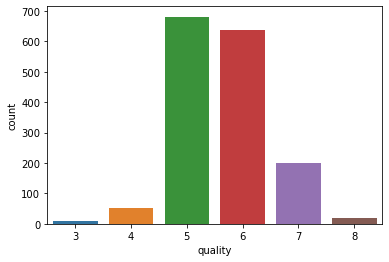

In [7]:
sns.countplot(x = 'quality', data=df)

In [8]:
class2idx = {
    3:0,
    4:1,
    5:2,
    6:3,
    7:4,
    8:5
}

idx2class = {v: k for k, v in class2idx.items()}

df['quality'].replace(class2idx, inplace=True)

In [9]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [10]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [12]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [13]:
def get_class_distribution(obj):
    count_dict = {
        "rating_3": 0,
        "rating_4": 0,
        "rating_5": 0,
        "rating_6": 0,
        "rating_7": 0,
        "rating_8": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['rating_3'] += 1
        elif i == 1: 
            count_dict['rating_4'] += 1
        elif i == 2: 
            count_dict['rating_5'] += 1
        elif i == 3: 
            count_dict['rating_6'] += 1
        elif i == 4: 
            count_dict['rating_7'] += 1  
        elif i == 5: 
            count_dict['rating_8'] += 1              
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

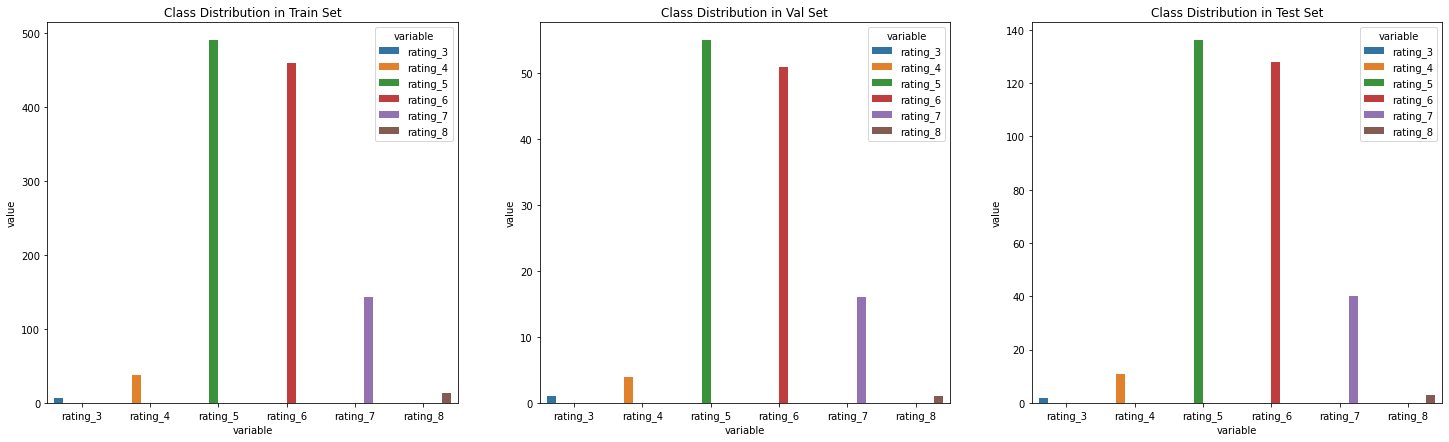

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(),
            x = "variable", y="value", hue="variable", 
            ax=axes[0]).set_title('Class Distribution in Train Set')# Validation


sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(),
            x = "variable", y="value", hue="variable", 
            ax=axes[1]).set_title('Class Distribution in Val Set')# Test


sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), 
            x = "variable", y="value", hue="variable",
            ax=axes[2]).set_title('Class Distribution in Test Set')

In [15]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(),
                                  torch.from_numpy(y_train).long())

val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), 
                                torch.from_numpy(y_val).long())

test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), 
                                 torch.from_numpy(y_test).long())

In [17]:
target_list = []

for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)

In [19]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float)
print(class_weights)

tensor([0.1429, 0.0263, 0.0020, 0.0022, 0.0070, 0.0714])


In [34]:
target_list[:20]

tensor([4, 3, 2, 3, 4, 3, 1, 4, 3, 3, 4, 3, 3, 3, 2, 2, 4, 2, 3, 3])

In [23]:
class_weights_all = class_weights[target_list]

In [24]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [26]:
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 6

In [27]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler)


val_loader = DataLoader(dataset=val_dataset, batch_size=1)


test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [28]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [32]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)

model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=11, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=6, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [38]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc



accuracy_stats = {
    'train': [],
    "val": []
}

loss_stats = {
    'train': [],
    "val": []
}

In [ ]:
print("Begin training.")for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    
model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()

In [44]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.81317 | Val Loss: 2.22607 | Train Acc: 39.389| Val Acc: 3.906
Epoch 002: | Train Loss: 0.46826 | Val Loss: 2.41633 | Train Acc: 42.083| Val Acc: 3.125
Epoch 003: | Train Loss: 0.33403 | Val Loss: 2.54364 | Train Acc: 48.319| Val Acc: 3.125
Epoch 004: | Train Loss: 0.29915 | Val Loss: 2.62060 | Train Acc: 47.583| Val Acc: 3.906
Epoch 005: | Train Loss: 0.30918 | Val Loss: 2.57096 | Train Acc: 47.917| Val Acc: 3.125
Epoch 006: | Train Loss: 0.27851 | Val Loss: 2.52659 | Train Acc: 49.625| Val Acc: 4.688
Epoch 007: | Train Loss: 0.24149 | Val Loss: 2.36095 | Train Acc: 50.625| Val Acc: 4.688
Epoch 008: | Train Loss: 0.27340 | Val Loss: 2.44945 | Train Acc: 50.806| Val Acc: 3.906
Epoch 009: | Train Loss: 0.25991 | Val Loss: 2.52260 | Train Acc: 51.694| Val Acc: 5.469
Epoch 010: | Train Loss: 0.22650 | Val Loss: 2.58869 | Train Acc: 52.806| Val Acc: 7.031
Epoch 011: | Train Loss: 0.22145 | Val Loss: 2.35360 | Train Acc: 55.389| Val Acc: 10.156
Epoch 012: | Train L

Epoch 093: | Train Loss: 0.08629 | Val Loss: 1.62450 | Train Acc: 69.944| Val Acc: 35.156
Epoch 094: | Train Loss: 0.08499 | Val Loss: 1.56664 | Train Acc: 72.139| Val Acc: 38.281
Epoch 095: | Train Loss: 0.10101 | Val Loss: 1.64846 | Train Acc: 72.306| Val Acc: 33.594
Epoch 096: | Train Loss: 0.10991 | Val Loss: 1.56761 | Train Acc: 69.778| Val Acc: 38.281
Epoch 097: | Train Loss: 0.08271 | Val Loss: 1.71711 | Train Acc: 74.375| Val Acc: 32.812
Epoch 098: | Train Loss: 0.09651 | Val Loss: 1.60077 | Train Acc: 72.000| Val Acc: 36.719
Epoch 099: | Train Loss: 0.06629 | Val Loss: 1.59464 | Train Acc: 74.514| Val Acc: 35.938
Epoch 100: | Train Loss: 0.08124 | Val Loss: 1.74003 | Train Acc: 73.792| Val Acc: 31.250
Epoch 101: | Train Loss: 0.07020 | Val Loss: 1.52236 | Train Acc: 73.083| Val Acc: 36.719
Epoch 102: | Train Loss: 0.07841 | Val Loss: 1.62399 | Train Acc: 73.042| Val Acc: 35.156
Epoch 103: | Train Loss: 0.07074 | Val Loss: 1.62395 | Train Acc: 73.722| Val Acc: 35.156
Epoch 104:

Epoch 185: | Train Loss: 0.05986 | Val Loss: 1.42187 | Train Acc: 76.306| Val Acc: 44.531
Epoch 186: | Train Loss: 0.05392 | Val Loss: 1.50869 | Train Acc: 77.819| Val Acc: 40.625
Epoch 187: | Train Loss: 0.06193 | Val Loss: 1.54701 | Train Acc: 76.708| Val Acc: 42.188
Epoch 188: | Train Loss: 0.07503 | Val Loss: 1.62600 | Train Acc: 74.986| Val Acc: 39.844
Epoch 189: | Train Loss: 0.06458 | Val Loss: 1.55919 | Train Acc: 77.944| Val Acc: 39.062
Epoch 190: | Train Loss: 0.06941 | Val Loss: 1.60384 | Train Acc: 74.667| Val Acc: 42.969
Epoch 191: | Train Loss: 0.07507 | Val Loss: 1.58063 | Train Acc: 75.625| Val Acc: 40.625
Epoch 192: | Train Loss: 0.07160 | Val Loss: 1.55537 | Train Acc: 75.389| Val Acc: 40.625
Epoch 193: | Train Loss: 0.08816 | Val Loss: 1.59139 | Train Acc: 75.014| Val Acc: 38.281
Epoch 194: | Train Loss: 0.07073 | Val Loss: 1.48309 | Train Acc: 74.167| Val Acc: 40.625
Epoch 195: | Train Loss: 0.05638 | Val Loss: 1.55156 | Train Acc: 77.375| Val Acc: 35.938
Epoch 196:

Epoch 277: | Train Loss: 0.06877 | Val Loss: 1.54077 | Train Acc: 79.778| Val Acc: 40.625
Epoch 278: | Train Loss: 0.05714 | Val Loss: 1.60091 | Train Acc: 76.500| Val Acc: 39.844
Epoch 279: | Train Loss: 0.05681 | Val Loss: 1.47428 | Train Acc: 79.667| Val Acc: 42.969
Epoch 280: | Train Loss: 0.05728 | Val Loss: 1.51517 | Train Acc: 78.431| Val Acc: 37.500
Epoch 281: | Train Loss: 0.09954 | Val Loss: 1.59753 | Train Acc: 74.792| Val Acc: 42.969
Epoch 282: | Train Loss: 0.06224 | Val Loss: 1.79229 | Train Acc: 77.625| Val Acc: 36.719
Epoch 283: | Train Loss: 0.07697 | Val Loss: 1.67050 | Train Acc: 77.083| Val Acc: 39.844
Epoch 284: | Train Loss: 0.06391 | Val Loss: 1.71094 | Train Acc: 77.083| Val Acc: 38.281
Epoch 285: | Train Loss: 0.06066 | Val Loss: 1.67893 | Train Acc: 79.708| Val Acc: 37.500
Epoch 286: | Train Loss: 0.04925 | Val Loss: 1.56639 | Train Acc: 79.000| Val Acc: 39.062
Epoch 287: | Train Loss: 0.04560 | Val Loss: 1.55056 | Train Acc: 78.278| Val Acc: 39.844
Epoch 288:

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

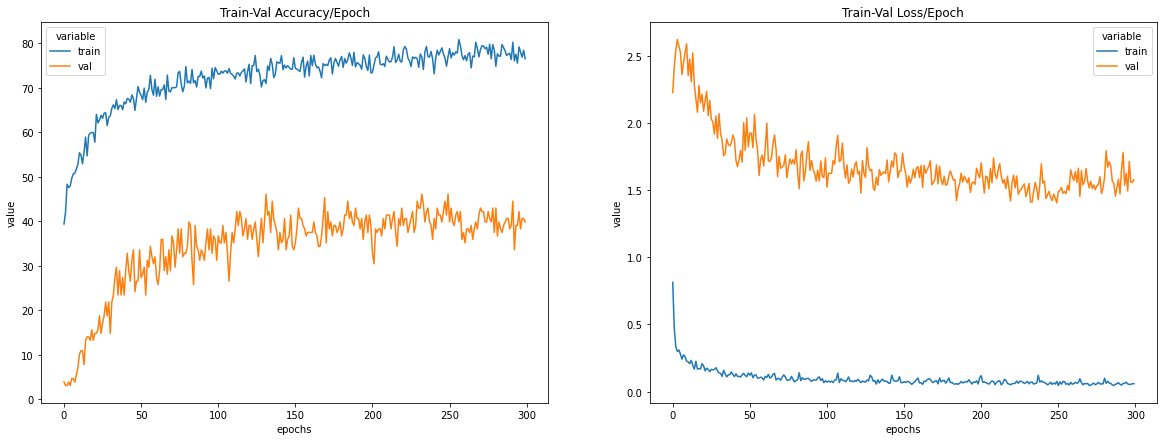

In [45]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats
                                         ).reset_index().melt(id_vars=['index']
                                                             ).rename(columns={"index":"epochs"})



train_val_loss_df = pd.DataFrame.from_dict(loss_stats
                                          ).reset_index().melt(id_vars=['index']
                                                                         ).rename(columns={"index":"epochs"})# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))


sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]
            ).set_title('Train-Val Accuracy/Epoch')

sns.lineplot(data=train_val_loss_df,
               x = "epochs", y="value", hue="variable", ax=axes[1]
                        ).set_title('Train-Val Loss/Epoch')

In [46]:
y_pred_list = []

with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

<AxesSubplot:>

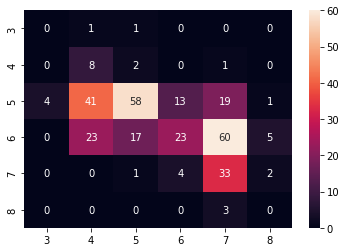

In [47]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)
                                  ).rename(columns=idx2class, index=idx2class)


sns.heatmap(confusion_matrix_df, annot=True)

In [48]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.11      0.73      0.19        11
           2       0.73      0.43      0.54       136
           3       0.57      0.18      0.27       128
           4       0.28      0.82      0.42        40
           5       0.00      0.00      0.00         3

    accuracy                           0.38       320
   macro avg       0.28      0.36      0.24       320
weighted avg       0.58      0.38      0.40       320



In [49]:
def compute_accuracy(y_true, y_pred):
    correct_predictions = 0
    # iterate over each label and check
    for true, predicted in zip(y_true, y_pred):
        if true == predicted:
            correct_predictions += 1
    # compute the accuracy
    accuracy = correct_predictions/len(y_true)
    return accuracy


compute_accuracy(y_test, y_pred_list)

0.38125